<a href="https://colab.research.google.com/github/wandersonlimabh-star/Analises-Wanderson/blob/main/WIN_Solicita%C3%A7%C3%B5es_Falar_Advisor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Faça upload do seu arquivo:


Saving Segmentados.xlsx to Segmentados.xlsx
Dados carregados com sucesso: 279 registros
Colunas disponíveis: ['data_inicio_interacao', 'id', 'cpf_cnpj', 'data_hora_abertura', 'caso_criado_por', 'alias_atendente_criador_do_caso', 'caso_filho', 'caso_pai', 'arvore_classificacao', 'texto']

=== IDENTIFICANDO SOLICITAÇÕES DE ESCALAÇÃO ===
Analisando colunas de texto: ['texto']

=== GERANDO ESTATÍSTICAS ===
=== ESTATÍSTICAS DE ESCALAÇÃO ===
Total de registros analisados: 279
Solicitações para Advisor: 15
Solicitações para Banking: 44
Solicitações para Gerente: 100
Registros com alguma solicitação: 135
Percentual de escalação: 48.39%

=== CRIANDO VISUALIZAÇÕES ===


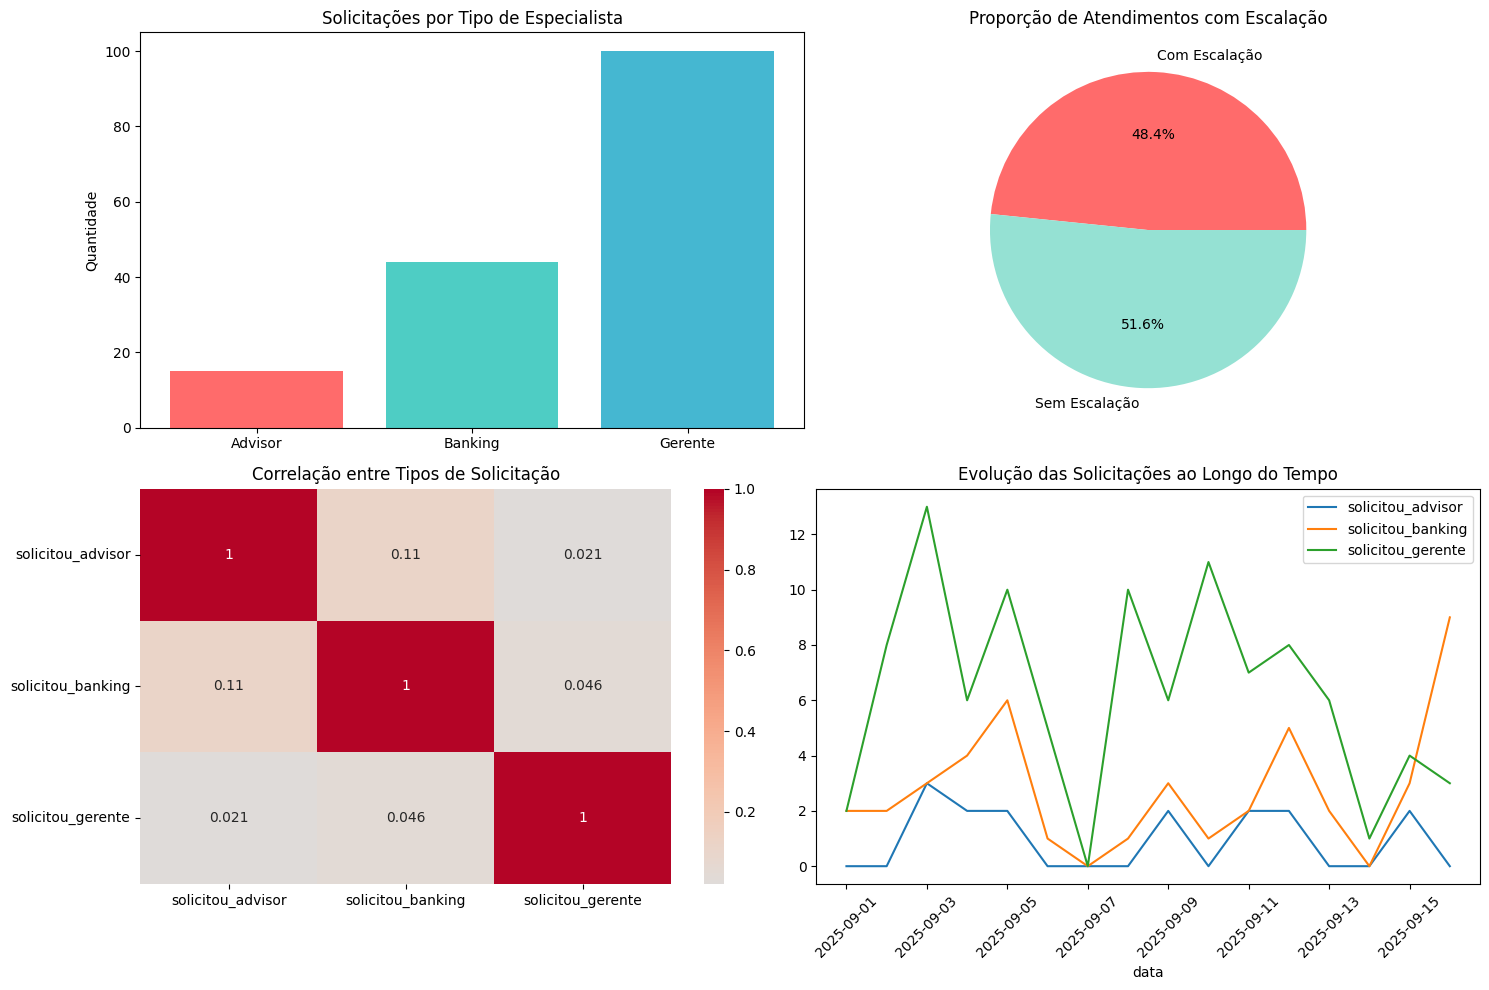


=== EXEMPLOS DE REGISTROS COM SOLICITAÇÕES ===

Registro 1:
  - Solicitou Gerente: ['responsável']

Registro 2:
  - Solicitou Gerente: ['responsável']

Registro 4:
  - Solicitou Gerente: ['responsável']

Registro 6:
  - Solicitou Banking: ['bancário']
  - Solicitou Gerente: ['responsável']

Registro 12:
  - Solicitou Banking: ['banco']

=== EXPORTANDO RESULTADOS ===
=== ESTATÍSTICAS DE ESCALAÇÃO ===
Total de registros analisados: 279
Solicitações para Advisor: 15
Solicitações para Banking: 44
Solicitações para Gerente: 100
Registros com alguma solicitação: 135
Percentual de escalação: 48.39%
Resultados exportados para: analise_escalacao_setembro_2024.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== ANÁLISE CONCLUÍDA ===
O arquivo Excel com os resultados foi gerado e está pronto para download!


In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Configuração para exibição completa dos dados
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

class AtendimentoAnalyzer:
    def __init__(self):
        self.df = None
        self.resultados = {}

    def carregar_dados(self, arquivo_path):
        """Carrega os dados do arquivo"""
        try:
            # Tenta diferentes formatos de arquivo
            if arquivo_path.endswith('.xlsx'):
                self.df = pd.read_excel(arquivo_path)
            elif arquivo_path.endswith('.csv'):
                self.df = pd.read_csv(arquivo_path, encoding='utf-8')
            else:
                # Tenta CSV com diferentes encodings
                try:
                    self.df = pd.read_csv(arquivo_path, encoding='utf-8')
                except:
                    self.df = pd.read_csv(arquivo_path, encoding='latin1')

            print(f"Dados carregados com sucesso: {len(self.df)} registros")
            print(f"Colunas disponíveis: {list(self.df.columns)}")
            return True

        except Exception as e:
            print(f"Erro ao carregar dados: {e}")
            return False

    def identificar_solicitacoes_escalacao(self):
        """Identifica menções a Advisor, Banking e Gerente nas conversas"""

        # Padrões de busca (case insensitive)
        padroes = {
            'advisor': [
                r'\badvisor\b', r'\badviser\b', r'\bconselheiro\b',
                r'quero falar com.*advisor', r'preciso de.*advisor',
                r'transferir.*advisor', r'passar.*advisor'
            ],
            'banking': [
                r'\bbanking\b', r'\bbanco\b', r'\bbancário\b',
                r'quero falar com.*banking', r'preciso.*banking',
                r'transferir.*banking', r'setor.*banking'
            ],
            'gerente': [
                r'\bgerente\b', r'\bgestor\b', r'\bmanager\b',
                r'quero falar com.*gerente', r'preciso.*gerente',
                r'transferir.*gerente', r'falar com.*supervisor',
                r'responsável', r'superior'
            ]
        }

        # Assumindo que existe uma coluna com o texto da conversa
        # Vamos procurar por colunas que possam conter texto
        colunas_texto = []
        for col in self.df.columns:
            if any(palavra in col.lower() for palavra in ['conversa', 'transcricao', 'texto', 'mensagem', 'chat', 'atendimento']):
                colunas_texto.append(col)

        if not colunas_texto:
            # Se não encontrar colunas específicas, usa todas as colunas de texto
            colunas_texto = [col for col in self.df.columns if self.df[col].dtype == 'object']

        print(f"Analisando colunas de texto: {colunas_texto}")

        # Inicializa resultados
        resultados = []

        for idx, row in self.df.iterrows():
            registro = {
                'indice': idx,
                'solicitou_advisor': False,
                'solicitou_banking': False,
                'solicitou_gerente': False,
                'mencoes_advisor': [],
                'mencoes_banking': [],
                'mencoes_gerente': [],
                'total_solicitacoes': 0
            }

            # Combina todo o texto das colunas relevantes
            texto_completo = ""
            for col in colunas_texto:
                if pd.notna(row[col]):
                    texto_completo += str(row[col]).lower() + " "

            # Busca por padrões
            for tipo, patterns in padroes.items():
                mencoes = []
                for pattern in patterns:
                    matches = re.findall(pattern, texto_completo, re.IGNORECASE)
                    mencoes.extend(matches)

                if mencoes:
                    registro[f'solicitou_{tipo}'] = True
                    registro[f'mencoes_{tipo}'] = mencoes
                    registro['total_solicitacoes'] += len(mencoes)

            # Adiciona dados originais
            for col in self.df.columns:
                if col not in registro:
                    registro[col] = row[col]

            resultados.append(registro)

        self.resultados_df = pd.DataFrame(resultados)
        return self.resultados_df

    def gerar_estatisticas(self):
        """Gera estatísticas da análise"""
        if self.resultados_df is None:
            print("Execute primeiro a identificação de solicitações")
            return

        stats = {
            'total_registros': len(self.resultados_df),
            'solicitacoes_advisor': self.resultados_df['solicitou_advisor'].sum(),
            'solicitacoes_banking': self.resultados_df['solicitou_banking'].sum(),
            'solicitacoes_gerente': self.resultados_df['solicitou_gerente'].sum(),
            'registros_com_solicitacao': len(self.resultados_df[
                (self.resultados_df['solicitou_advisor']) |
                (self.resultados_df['solicitou_banking']) |
                (self.resultados_df['solicitou_gerente'])
            ])
        }

        stats['percentual_escalacao'] = (stats['registros_com_solicitacao'] / stats['total_registros']) * 100

        print("=== ESTATÍSTICAS DE ESCALAÇÃO ===")
        print(f"Total de registros analisados: {stats['total_registros']}")
        print(f"Solicitações para Advisor: {stats['solicitacoes_advisor']}")
        print(f"Solicitações para Banking: {stats['solicitacoes_banking']}")
        print(f"Solicitações para Gerente: {stats['solicitacoes_gerente']}")
        print(f"Registros com alguma solicitação: {stats['registros_com_solicitacao']}")
        print(f"Percentual de escalação: {stats['percentual_escalacao']:.2f}%")

        return stats

    def criar_visualizacoes(self):
        """Cria visualizações dos dados"""
        if self.resultados_df is None:
            return

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Gráfico 1: Distribuição de solicitações por tipo
        tipos = ['Advisor', 'Banking', 'Gerente']
        valores = [
            self.resultados_df['solicitou_advisor'].sum(),
            self.resultados_df['solicitou_banking'].sum(),
            self.resultados_df['solicitou_gerente'].sum()
        ]

        axes[0,0].bar(tipos, valores, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
        axes[0,0].set_title('Solicitações por Tipo de Especialista')
        axes[0,0].set_ylabel('Quantidade')

        # Gráfico 2: Pizza - Proporção de escalações
        com_escalacao = len(self.resultados_df[
            (self.resultados_df['solicitou_advisor']) |
            (self.resultados_df['solicitou_banking']) |
            (self.resultados_df['solicitou_gerente'])
        ])
        sem_escalacao = len(self.resultados_df) - com_escalacao

        axes[0,1].pie([com_escalacao, sem_escalacao],
                     labels=['Com Escalação', 'Sem Escalação'],
                     autopct='%1.1f%%',
                     colors=['#FF6B6B', '#95E1D3'])
        axes[0,1].set_title('Proporção de Atendimentos com Escalação')

        # Gráfico 3: Heatmap de solicitações
        dados_heatmap = self.resultados_df[['solicitou_advisor', 'solicitou_banking', 'solicitou_gerente']].astype(int)
        correlacao = dados_heatmap.corr()
        sns.heatmap(correlacao, annot=True, cmap='coolwarm', center=0, ax=axes[1,0])
        axes[1,0].set_title('Correlação entre Tipos de Solicitação')

        # Gráfico 4: Evolução temporal (se houver coluna de data)
        colunas_data = [col for col in self.df.columns if 'data' in col.lower() or 'date' in col.lower()]
        if colunas_data:
            try:
                self.resultados_df['data'] = pd.to_datetime(self.df[colunas_data[0]])
                escalacoes_por_dia = self.resultados_df.groupby(self.resultados_df['data'].dt.date)[
                    ['solicitou_advisor', 'solicitou_banking', 'solicitou_gerente']
                ].sum()

                escalacoes_por_dia.plot(kind='line', ax=axes[1,1])
                axes[1,1].set_title('Evolução das Solicitações ao Longo do Tempo')
                axes[1,1].tick_params(axis='x', rotation=45)
            except:
                axes[1,1].text(0.5, 0.5, 'Dados de data não disponíveis',
                              ha='center', va='center', transform=axes[1,1].transAxes)
        else:
            axes[1,1].text(0.5, 0.5, 'Dados de data não encontrados',
                          ha='center', va='center', transform=axes[1,1].transAxes)

        plt.tight_layout()
        plt.show()

    def exportar_resultados(self, nome_arquivo='analise_escalacao_resultados.xlsx'):
        """Exporta os resultados para Excel"""
        if self.resultados_df is None:
            print("Nenhum resultado para exportar")
            return

        with pd.ExcelWriter(nome_arquivo, engine='openpyxl') as writer:
            # Aba 1: Dados completos
            self.resultados_df.to_excel(writer, sheet_name='Dados_Completos', index=False)

            # Aba 2: Apenas registros com solicitações
            registros_com_solicitacao = self.resultados_df[
                (self.resultados_df['solicitou_advisor']) |
                (self.resultados_df['solicitou_banking']) |
                (self.resultados_df['solicitou_gerente'])
            ]
            registros_com_solicitacao.to_excel(writer, sheet_name='Com_Solicitacoes', index=False)

            # Aba 3: Resumo estatístico
            stats = self.gerar_estatisticas()
            stats_df = pd.DataFrame(list(stats.items()), columns=['Métrica', 'Valor'])
            stats_df.to_excel(writer, sheet_name='Estatisticas', index=False)

            # Aba 4: Análise por tipo
            analise_tipo = pd.DataFrame({
                'Tipo': ['Advisor', 'Banking', 'Gerente'],
                'Quantidade': [
                    self.resultados_df['solicitou_advisor'].sum(),
                    self.resultados_df['solicitou_banking'].sum(),
                    self.resultados_df['solicitou_gerente'].sum()
                ],
                'Percentual': [
                    (self.resultados_df['solicitou_advisor'].sum() / len(self.resultados_df)) * 100,
                    (self.resultados_df['solicitou_banking'].sum() / len(self.resultados_df)) * 100,
                    (self.resultados_df['solicitou_gerente'].sum() / len(self.resultados_df)) * 100
                ]
            })
            analise_tipo.to_excel(writer, sheet_name='Analise_por_Tipo', index=False)

        print(f"Resultados exportados para: {nome_arquivo}")

# === EXECUÇÃO PRINCIPAL ===

# Inicializa o analisador
analyzer = AtendimentoAnalyzer()

# PASSO 1: Carregue seu arquivo aqui
# Substitua 'seu_arquivo.xlsx' pelo caminho do seu arquivo
arquivo_path = 'seu_arquivo.xlsx'  # Ajuste conforme necessário

# Upload do arquivo no Google Colab
from google.colab import files
print("Faça upload do seu arquivo:")
uploaded = files.upload()

# Pega o nome do arquivo carregado
arquivo_path = list(uploaded.keys())[0]

# PASSO 2: Carrega e analisa os dados
if analyzer.carregar_dados(arquivo_path):

    # PASSO 3: Identifica solicitações de escalação
    print("\n=== IDENTIFICANDO SOLICITAÇÕES DE ESCALAÇÃO ===")
    resultados = analyzer.identificar_solicitacoes_escalacao()

    # PASSO 4: Gera estatísticas
    print("\n=== GERANDO ESTATÍSTICAS ===")
    stats = analyzer.gerar_estatisticas()

    # PASSO 5: Cria visualizações
    print("\n=== CRIANDO VISUALIZAÇÕES ===")
    analyzer.criar_visualizacoes()

    # PASSO 6: Mostra alguns exemplos
    print("\n=== EXEMPLOS DE REGISTROS COM SOLICITAÇÕES ===")
    exemplos = resultados[
        (resultados['solicitou_advisor']) |
        (resultados['solicitou_banking']) |
        (resultados['solicitou_gerente'])
    ].head()

    for idx, row in exemplos.iterrows():
        print(f"\nRegistro {row['indice']}:")
        if row['solicitou_advisor']:
            print(f"  - Solicitou Advisor: {row['mencoes_advisor']}")
        if row['solicitou_banking']:
            print(f"  - Solicitou Banking: {row['mencoes_banking']}")
        if row['solicitou_gerente']:
            print(f"  - Solicitou Gerente: {row['mencoes_gerente']}")

    # PASSO 7: Exporta resultados
    print("\n=== EXPORTANDO RESULTADOS ===")
    analyzer.exportar_resultados('analise_escalacao_setembro_2024.xlsx')

    # Download do arquivo resultado
    files.download('analise_escalacao_setembro_2024.xlsx')

    print("\n=== ANÁLISE CONCLUÍDA ===")
    print("O arquivo Excel com os resultados foi gerado e está pronto para download!")

else:
    print("Erro ao carregar o arquivo. Verifique o formato e tente novamente.")

# === ANÁLISE ADICIONAL (OPCIONAL) ===

# Função para análise de padrões específicos
def analise_avancada(analyzer):
    """Análise mais detalhada dos padrões encontrados"""
    if analyzer.resultados_df is None:
        return

    print("\n=== ANÁLISE AVANÇADA ===")

    # Padrões mais frequentes
    todas_mencoes = []
    for _, row in analyzer.resultados_df.iterrows():
        todas_mencoes.extend(row['mencoes_advisor'])
        todas_mencoes.extend(row['mencoes_banking'])
        todas_mencoes.extend(row['mencoes_gerente'])

    if todas_mencoes:
        contador = Counter(todas_mencoes)
        print("\nPadrões mais frequentes:")
        for padrao, freq in contador.most_common(10):
            print(f"  {padrao}: {freq} vezes")

    # Análise de combinações
    combinacoes = analyzer.resultados_df[
        (analyzer.resultados_df['solicitou_advisor']) &
        (analyzer.resultados_df['solicitou_banking']) |
        (analyzer.resultados_df['solicitou_advisor']) &
        (analyzer.resultados_df['solicitou_gerente']) |
        (analyzer.resultados_df['solicitou_banking']) &
        (analyzer.resultados_df['solicitou_gerente'])
    ]

    print(f"\nRegistros com múltiplas solicitações: {len(combinacoes)}")

# Execute a análise avançada se desejar
# analise_avancada(analyzer)